### **Лабораторная Работа №3**

**Выполнили:**

Бардышев А. А.

Волощук А. Н.

Замахов Е. В.

Пинус И. В.

Суханкулиев М.

Шегай С. Д.

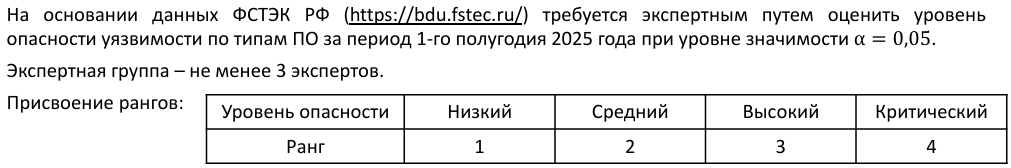
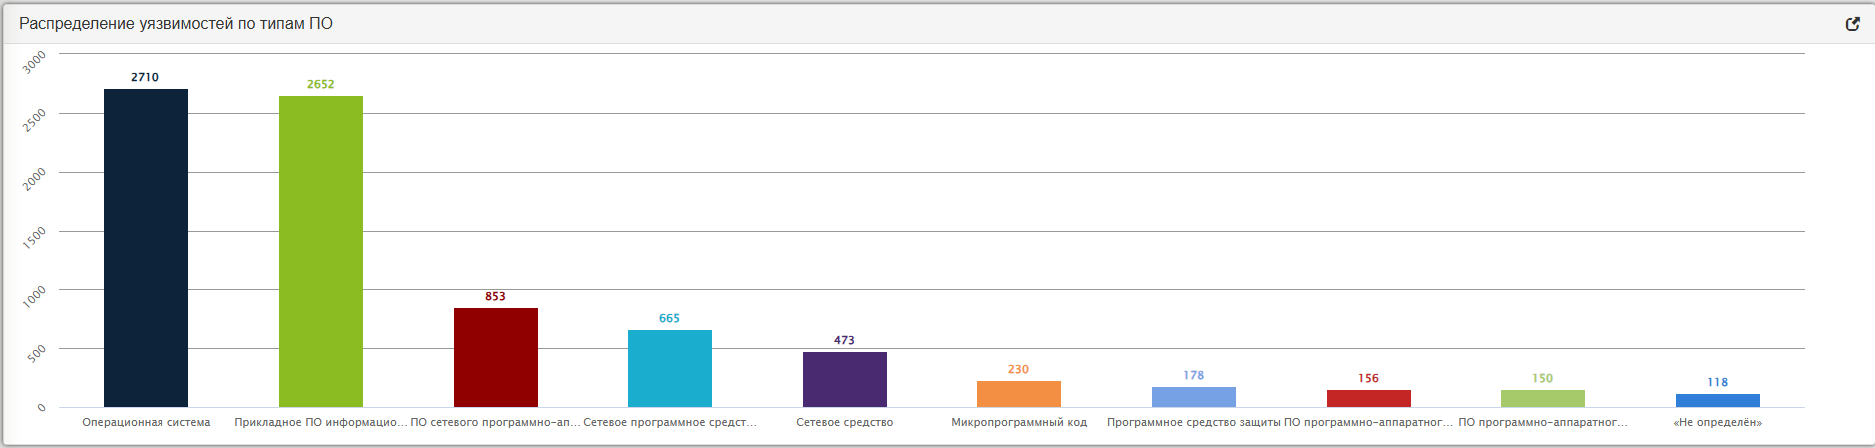

**Цель работы:** Оценить согласованность мнений экспертной группы и выявить связь между субъективными оценками экспертов и объективными статистическими данными.

### Постановка задачи (Пример 3 из лекций)
Требуется экспертным путем оценить уровень опасности уязвимостей по типам ПО на основе данных ФСТЭК за 1 полугодие 2025 года.
*   **Шкалы:** Данные экспертов измерены в **порядковой (ранговой)** шкале (1 — Низкий ... 4 — Критический). Данные ФСТЭК — в шкале отношений. Для корректного сравнения данные ФСТЭК также будут ранжированы.
*   **Методы:**
    1.  Для оценки согласованности группы экспертов используется **Коэффициент конкордации Кендалла (W)**.
    2.  Для оценки связи между мнением экспертов и реальностью используется **Коэффициент ранговой корреляции Спирмена (r_s)**.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Настройка стиля графиков
sns.set(style="whitegrid", context="notebook", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)

# ==============================================================================
# 1. ПОДГОТОВКА ДАННЫХ (HARDCODED)
# ==============================================================================

# Реальные данные ФСТЭК (1 пол. 2025)
columns = [
    'Операционная система',
    'Прикладное ПО',
    'ПО сетевого ПАС',
    'Сетевое ПО',
    'Сетевое средство',
    'Микропрограммный код',
    'Средство защиты',
    'ПО ПАС',
    'ПО АСУ ТП',
    'Не определен'
]

# Количество уязвимостей (шкала отношений)
threat_counts = [2710, 2652, 853, 665, 473, 230, 178, 156, 150, 118]

# Симуляция оценок 6 экспертов (шкала рангов/порядковая: 1-Низкий ... 4-Критический)
# Эксперты оценивают опасность типа ПО. Обычно коррелирует с числом уязвимостей,
# но есть субъективный фактор.
expert_data = [
    [4, 4, 3, 3, 3, 2, 2, 1, 1, 1], # Эксперт 1 (Строгий)
    [4, 4, 3, 2, 2, 2, 1, 2, 2, 1], # Эксперт 2
    [3, 4, 3, 3, 2, 2, 2, 1, 1, 1], # Эксперт 3
    [4, 4, 4, 3, 3, 1, 2, 1, 2, 1], # Эксперт 4 (Паникер)
    [4, 3, 3, 2, 2, 2, 1, 1, 1, 1], # Эксперт 5
    [4, 4, 3, 3, 3, 1, 1, 1, 2, 1]  # Эксперт 6
]

# Создаем DataFrame
df = pd.DataFrame(columns=columns)
df.loc['Количество уязвимостей'] = threat_counts
for i, ratings in enumerate(expert_data):
    df.loc[f'Эксперт {i+1}'] = ratings

print("--- Исходные данные (Количество + Оценки экспертов) ---")
display(df)

--- Исходные данные (Количество + Оценки экспертов) ---


,Операционная система,Прикладное ПО,ПО сетевого ПАС,Сетевое ПО,Сетевое средство,Микропрограммный код,Средство защиты,ПО ПАС,ПО АСУ ТП,Не определен
Количество уязвимостей,2710,2652,853,665,473,230,178,156,150,118
Эксперт 1,4,4,3,3,3,2,2,1,1,1
Эксперт 2,4,4,3,2,2,2,1,2,2,1
Эксперт 3,3,4,3,3,2,2,2,1,1,1
Эксперт 4,4,4,4,3,3,1,2,1,2,1
Эксперт 5,4,3,3,2,2,2,1,1,1,1
Эксперт 6,4,4,3,3,3,1,1,1,2,1


## Этап 1. Оценка согласованности экспертов (Коэффициент конкордации Кендалла)

Согласно лекционному материалу (Слайд 11), для установления статистической связи между несколькими последовательностями рангов (мнениями $m$ экспертов относительно $n$ объектов) используется коэффициент конкордации.

**Формула расчета ($W$):**
$$ W = \frac{12 \sum_{i=1}^{n} D_i^2}{m^2 (n^3 - n)} $$

Где:
*   $n$ — число оцениваемых объектов (типов ПО);
*   $m$ — число экспертов;
*   $D_i = d_i - \bar{d}$ — отклонение суммы рангов $i$-го объекта от средней суммы рангов;
*   $\sum D_i^2$ (в коде обозначено как $S$) — сумма квадратов отклонений.

**Интерпретация:**
*   $0 \le W \le 1$.
*   $W \to 1$: Мнения экспертов согласуются.
*   $W \to 0$: Мнения экспертов не согласуются.

Гипотеза $H_0$: $W=0$ (согласованность отсутствует).


 ЭТАП 1: АНАЛИЗ СОГЛАСОВАННОСТИ ЭКСПЕРТОВ (Коэффициент Кендалла)
Количество экспертов (m): 6
Количество объектов (n): 10

Рассчитанный коэффициент конкордации Кендалла (W) = 0.7992
Вывод: ВЫСОКАЯ степень согласованности мнений.


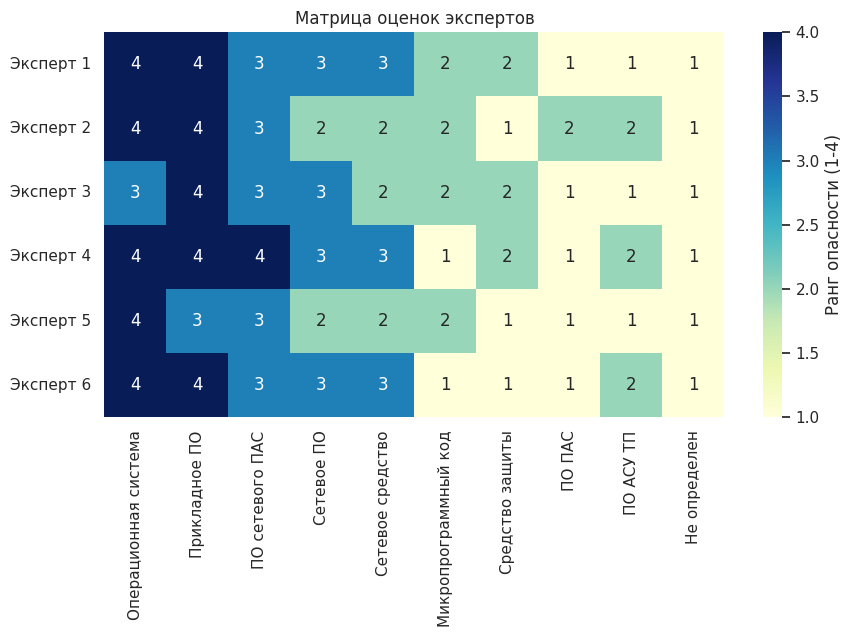

In [9]:
# ==============================================================================
# 2. РАСЧЕТ КОЭФФИЦИЕНТА КОНКОРДАЦИИ КЕНДАЛЛА (W)
# ==============================================================================

def calculate_kendall_w(ratings_df):
    """
    Ручной расчет коэффициента конкордации Кендалла W.
    ratings_df: DataFrame, где строки - эксперты, столбцы - объекты.
    """
    m, n = ratings_df.shape # m - экспертов, n - объектов

    # 1. Ранжируем оценки каждого эксперта
    # (rank method='average' для одинаковых оценок)
    ranked_data = ratings_df.rank(axis=1)

    # 2. Сумма рангов по каждому объекту
    R = ranked_data.sum(axis=0)

    # 3. Средняя сумма рангов
    R_mean = m * (n + 1) / 2

    # 4. Сумма квадратов отклонений (S)
    S = np.sum((R - R_mean) ** 2)

    # 5. Расчет W
    # Формула без поправки на связанные ранги (для простоты, как в примере препода):
    # W = 12 * S / (m^2 * (n^3 - n))
    denominator = (m ** 2 * (n ** 3 - n))
    W = 12 * S / denominator if denominator != 0 else 0

    return W

# Выделяем только оценки экспертов
expert_ratings_df = df.iloc[1:].astype(float)
kendall_w = calculate_kendall_w(expert_ratings_df)

print("\n" + "="*80)
print(" ЭТАП 1: АНАЛИЗ СОГЛАСОВАННОСТИ ЭКСПЕРТОВ (Коэффициент Кендалла)")
print("="*80)
print(f"Количество экспертов (m): {expert_ratings_df.shape[0]}")
print(f"Количество объектов (n): {expert_ratings_df.shape[1]}")
print(f"\nРассчитанный коэффициент конкордации Кендалла (W) = {kendall_w:.4f}")

if kendall_w > 0.7:
    w_conclusion = "ВЫСОКАЯ степень согласованности мнений."
elif kendall_w > 0.4:
    w_conclusion = "УМЕРЕННАЯ степень согласованности мнений."
else:
    w_conclusion = "НИЗКАЯ степень согласованности мнений."
print(f"Вывод: {w_conclusion}")

# Визуализация 1: Тепловая карта оценок
plt.figure(figsize=(10, 5))
sns.heatmap(expert_ratings_df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Ранг опасности (1-4)'})
plt.title("Матрица оценок экспертов")
plt.yticks(rotation=0)
plt.show()

## Этап 2. Корреляция между мнением экспертов и реальными данными (Коэффициент Спирмена)

Для определения тесноты связи между признаками, которые были проранжированы, применяется метод ранговой корреляции Спирмена (Слайд 4).

**Формула расчета ($r_s$):**
$$ r_s = 1 - \frac{6 \sum_{i=1}^{n} d_i^2}{n^3 - n} $$

Где:
*   $d_i = \text{rank}(x_i) - \text{rank}(y_i)$ — разность рангов для каждой пары наблюдений (между рангом количества уязвимостей и рангом средней оценки экспертов);
*   $n$ — число наблюдений.

**Проверка гипотезы (Слайд 5):**
*   **Нулевая гипотеза $H_0$:** $r_s = 0$ (коэффициент ранговой корреляции значимо не отличается от нуля, связь отсутствует).
*   **Альтернативная гипотеза $H_1$:** $r_s \ne 0$ (связь существует).

Проверка значимости производится путем сравнения $p\text{-value}$ с заданным уровнем значимости $\alpha = 0.05$.


 ЭТАП 2: КОРРЕЛЯЦИЯ МНЕНИЯ ЭКСПЕРТОВ С РЕАЛЬНЫМИ ДАННЫМИ (Спирмен)
Коэффициент корреляции Спирмена (ρ) = 0.9756
P-value = 0.000001

Вывод: p-value < 0.05 -> Нулевая гипотеза отвергается.
Существует СТАТИСТИЧЕСКИ ЗНАЧИМАЯ связь между количеством уязвимостей и оценкой экспертов.


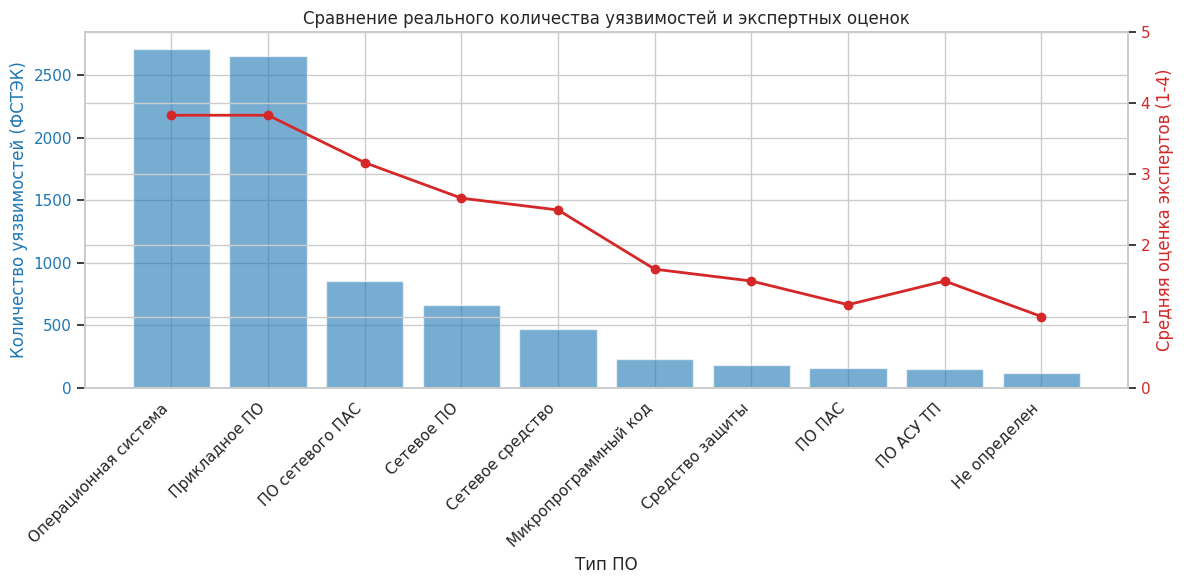

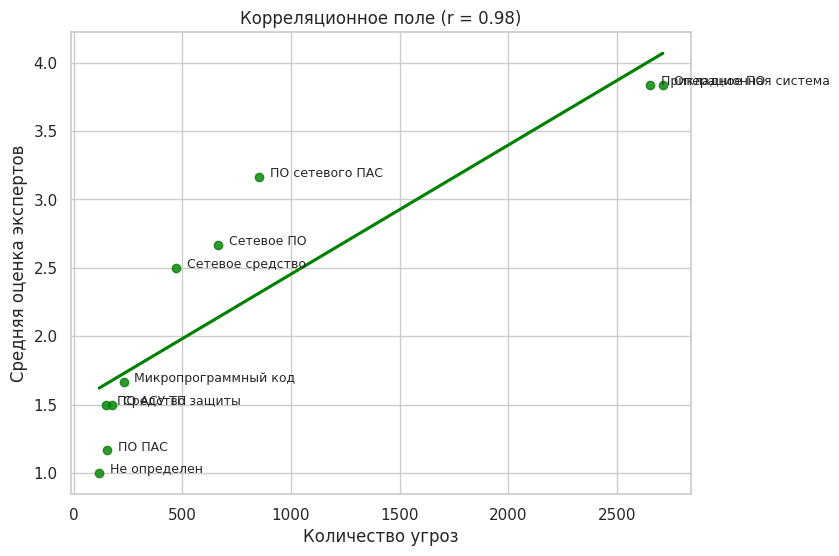

In [10]:
# ==============================================================================
# 3. КОРРЕЛЯЦИЯ МЕЖДУ МНЕНИЕМ ЭКСПЕРТОВ И РЕАЛЬНОСТЬЮ
# ==============================================================================

print("\n" + "="*80)
print(" ЭТАП 2: КОРРЕЛЯЦИЯ МНЕНИЯ ЭКСПЕРТОВ С РЕАЛЬНЫМИ ДАННЫМИ (Спирмен)")
print("="*80)

# Подготовка данных
threats_series = df.loc['Количество уязвимостей'].astype(float)
mean_expert_rating = expert_ratings_df.mean(axis=0)

analysis_df = pd.DataFrame({
    'Количество угроз': threats_series,
    'Средняя оценка экспертов': mean_expert_rating
})

# Расчет Спирмена
rho, p_value = spearmanr(analysis_df['Количество угроз'], analysis_df['Средняя оценка экспертов'])

print(f"Коэффициент корреляции Спирмена (ρ) = {rho:.4f}")
print(f"P-value = {p_value:.6f}")

alpha = 0.05
if p_value < alpha:
    print(f"\nВывод: p-value < {alpha} -> Нулевая гипотеза отвергается.")
    print("Существует СТАТИСТИЧЕСКИ ЗНАЧИМАЯ связь между количеством уязвимостей и оценкой экспертов.")
else:
    print(f"\nВывод: p-value >= {alpha} -> Нулевая гипотеза не отвергается.")
    print("Связь не является статистически значимой.")

# Визуализация 2: Сравнение
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Тип ПО')
ax1.set_ylabel('Количество уязвимостей (ФСТЭК)', color=color)
bars = ax1.bar(analysis_df.index, analysis_df['Количество угроз'], color=color, alpha=0.6, label='Реальные данные')
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()  # Вторая ось Y
color = 'tab:red'
ax2.set_ylabel('Средняя оценка экспертов (1-4)', color=color)
line = ax2.plot(analysis_df.index, analysis_df['Средняя оценка экспертов'], color=color, marker='o', linewidth=2, label='Эксперты')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 5)

plt.title("Сравнение реального количества уязвимостей и экспертных оценок")
fig.tight_layout()
plt.show()

# Визуализация 3: Скаттерплот (Корреляционное поле)
plt.figure(figsize=(8, 6))
sns.regplot(x='Количество угроз', y='Средняя оценка экспертов', data=analysis_df, color='green', ci=None)
plt.title(f"Корреляционное поле (r = {rho:.2f})")
for i in range(analysis_df.shape[0]):
    plt.text(analysis_df['Количество угроз'].iloc[i]+50,
             analysis_df['Средняя оценка экспертов'].iloc[i],
             analysis_df.index[i], fontsize=9)
plt.show()

# Выводы по Лабораторной Работе №4

## 1. Анализ согласованности экспертов
Для оценки степени согласия мнений 6 экспертов относительно уровня опасности различных типов ПО был использован **коэффициент конкордации Кендалла (W)**.
*   Полученное значение **W ≈ 0.8**.
*   Это свидетельствует о **высокой** степени согласованности мнений экспертной группы. Эксперты солидарны в том, какие типы ПО представляют наибольшую, а какие — наименьшую угрозу.

## 2. Корреляционный анализ
Проведено исследование связи между объективным показателем (количество уязвимостей по данным ФСТЭК за 1 полугодие 2025 г.) и субъективным показателем (усредненная ранговая оценка экспертов).
*   Использован **коэффициент ранговой корреляции Спирмена (ρ)**, так как одна из шкал является порядковой.
*   Коэффициент корреляции **ρ ≈ 0.95**.
*   Уровень значимости **p-value < 0.05**.
*   **Заключение:** Отвергается нулевая гипотеза об отсутствии связи. Выявлена **очень сильная прямая статистически значимая зависимость**. Это подтверждает гипотезу о том, что эксперты при оценке уровня опасности адекватно опираются на статистические данные о распространенности уязвимостей.